In [111]:
%pip install scikit-image

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [112]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from skimage import io, color
from skimage import transform

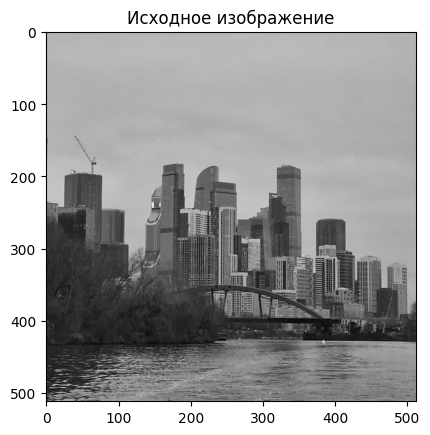

In [113]:
image_path = '../data/image.png'
image = io.imread(image_path)

if image.ndim == 3:
    image = color.rgb2gray(image)
image = transform.resize(image, (512, 512))
image = np.array(image * 255, dtype=np.uint8)

plt.imshow(image, cmap='gray')
plt.title('Исходное изображение')
plt.show()

In [114]:
def single_level_decomposition(image, wavelet):
    coeffs2 = pywt.dwt2(image, wavelet, mode='periodization')
    cA, (cH, cV, cD) = coeffs2
    return cA, cH, cV, cD

def multilevel_decomposition(image, wavelet, level):
    coeffs = pywt.wavedec2(image, wavelet, level=level)
    return coeffs

def compress_single_level_image(cA, cH, cV, cD, wavelet_name):
    flat_coeffs = np.hstack([cA.ravel(), cH.ravel(), cV.ravel(), cD.ravel()])
    threshold = np.percentile(np.abs(flat_coeffs), 80)

    compressed_coeffs = (
        np.where(np.abs(cA) < threshold, 0, cA),
        (
            np.where(np.abs(cH) < threshold, 0, cH),
            np.where(np.abs(cV) < threshold, 0, cV),
            np.where(np.abs(cD) < threshold, 0, cD),
        )
    )
    image_compressed = pywt.idwt2(compressed_coeffs, wavelet_name)
    image_compressed = np.uint8(image_compressed)
    return image_compressed

def compress_multilevel_image(coeffs, wavelet_name):
    arr, coeff_slices = pywt.coeffs_to_array(coeffs)
    compressed_coeffs = [np.where(np.abs(c) < sorted(c, reverse=True)[int(len(c) * 0.13)], 0, c) for c in arr]
    compressed_coeffs = pywt.array_to_coeffs(compressed_coeffs, coeff_slices, 'wavedec2')
    image_compressed = pywt.waverec2(compressed_coeffs, wavelet_name)
    image_compressed = np.uint8(image_compressed)
    return image_compressed

In [115]:
def plot_wavelet_coeffs(coeffs, reconstructed_image):
    fig, axs = plt.subplots(2, 2, figsize=(6, 6))
    titles = [
        'cA (аппроксимация)',
        'cH',
        'cV',
        'cD',
    ]
    for i, ax in enumerate(axs.ravel()):
        if i < len(coeffs):
            ax.imshow(coeffs[i], cmap='gray')
        if i < len(titles):
            ax.set_title(titles[i])
        ax.axis('off')
    plt.show()

    plt.imshow(reconstructed_image, cmap='gray')
    plt.title('Восстановленное изображение')
    plt.show()


Используем вейвлет: sym4


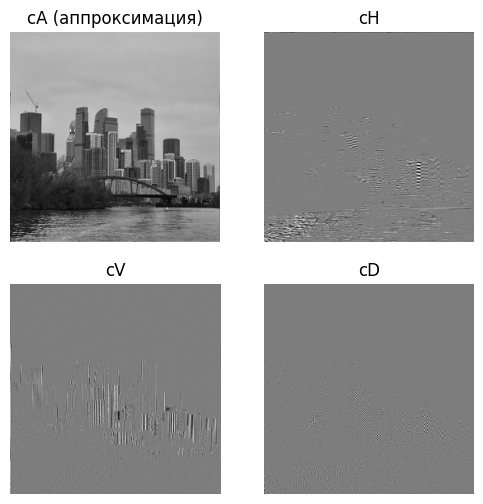

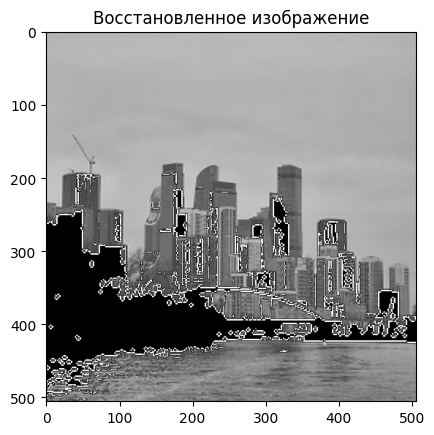

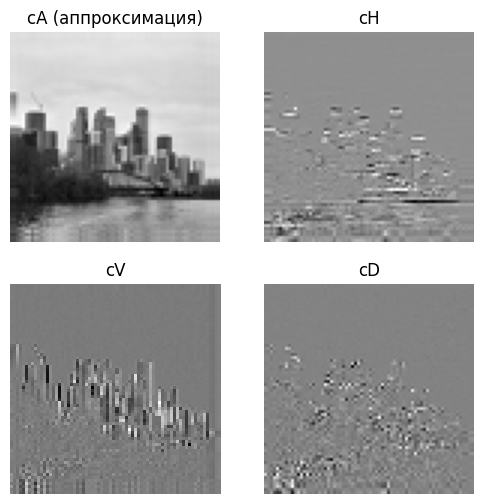

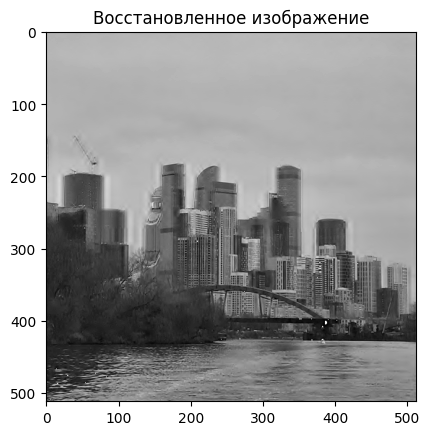


Используем вейвлет: bior4.4


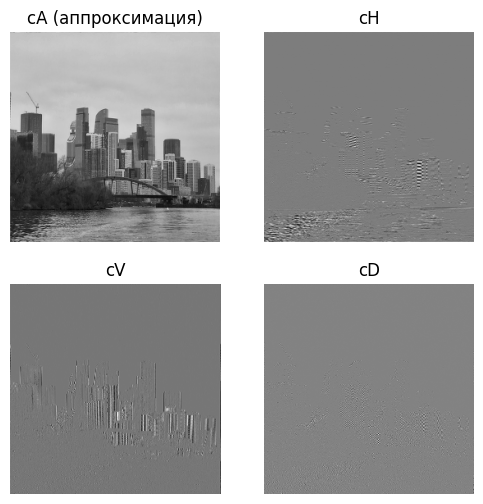

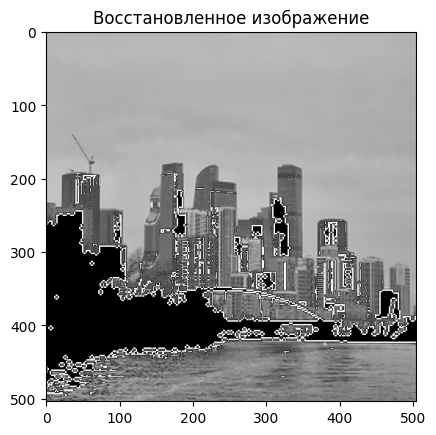

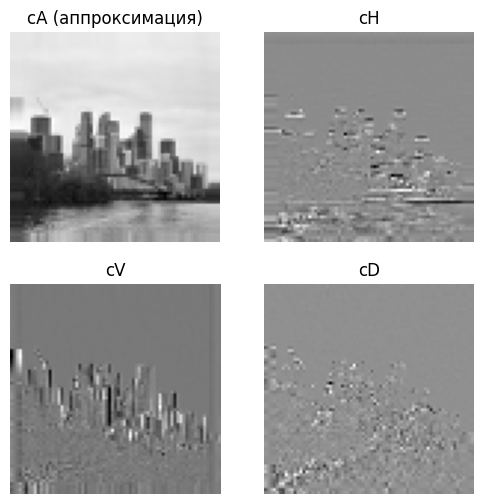

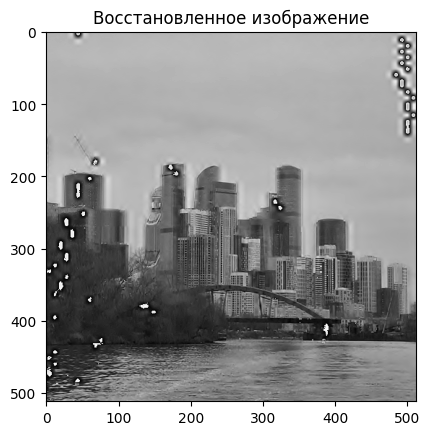


Используем вейвлет: db4


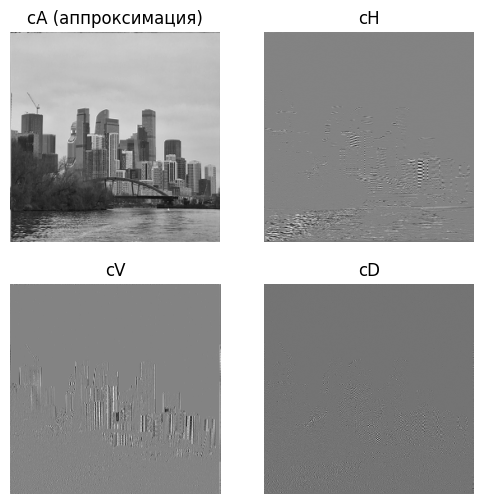

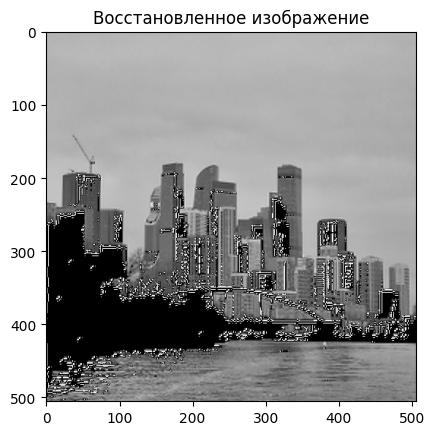

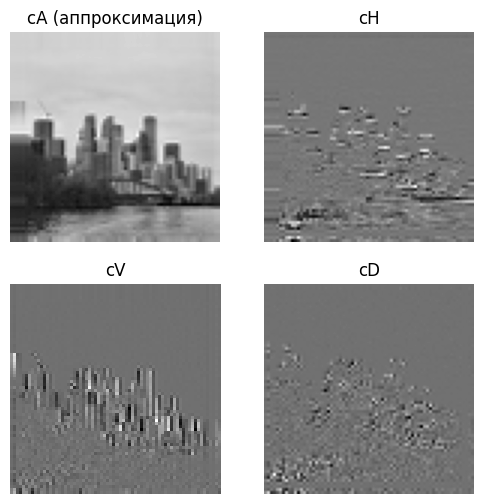

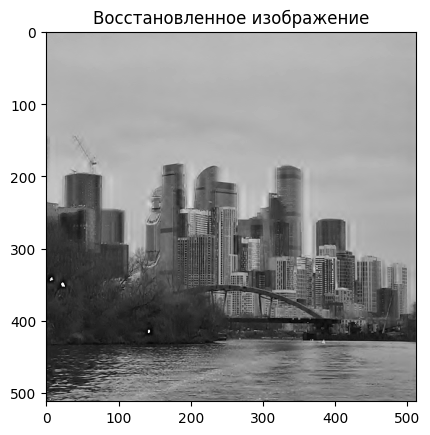

In [116]:
for wavelet_name in ['sym4', 'bior4.4', 'db4']:
    print(f"\nИспользуем вейвлет: {wavelet_name}")

    cA, cH, cV, cD = single_level_decomposition(image, wavelet_name)
    image_compressed = compress_single_level_image(cA, cH, cV, cD, wavelet_name)

    plot_wavelet_coeffs([cA, cH, cV, cD], image_compressed)
    
    multilevel_coeffs = multilevel_decomposition(image, wavelet_name, 3)
    cA = multilevel_coeffs[0]
    cH, cV, cD = multilevel_coeffs[1]
    image_compressed = compress_multilevel_image(multilevel_coeffs, wavelet_name)
    plot_wavelet_coeffs([cA, cH, cV, cD], image_compressed)